# AI 세금이 기업 투자와 경제 성장에 미치는 영향?

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS, RandomEffects
from scipy import stats

file_path = "../data/master_data_by_category.csv"
df = pd.read_csv(file_path)

years = [str(y) for y in range(2013, 2023)]
df_long = df.melt(id_vars=['Country', 'category'], value_vars=years,
                  var_name='Year', value_name='Value')
df_long['Year'] = df_long['Year'].astype(int)

# Wide Format (패널 데이터)
panel_df = df_long.pivot(index=['Country', 'Year'], columns='category', values='Value')
panel_df.sort_index(level=['Country', 'Year'], inplace=True)

for col in panel_df.columns:
    panel_df[col] = pd.to_numeric(panel_df[col], errors='coerce')

### 기업 투자 모델
- Patent Publications ~ WIPO Tax, Corporate Tax

In [40]:
model_inv_df = panel_df[['Patent Publications', 'WIPO Tax', 'Corporate Tax']].dropna()
model_inv_df = model_inv_df.reset_index()
panel_inv = model_inv_df.set_index(['Country', 'Year'])

y_inv = panel_inv['Patent Publications']
X_inv = panel_inv[['WIPO Tax', 'Corporate Tax']]
X_inv = sm.add_constant(X_inv)

# Fixed Effects
fe_model_inv = PanelOLS(y_inv, X_inv, entity_effects=True)
fe_res_inv = fe_model_inv.fit(cov_type='clustered', cluster_entity=True)

# Random Effects
re_model_inv = RandomEffects(y_inv, X_inv)
re_res_inv = re_model_inv.fit()

### 경제 성장 모델
- GDP ~ WIPO Tax, Corporate Tax

In [41]:
model_gdp_df = panel_df[['GDP', 'WIPO Tax', 'Corporate Tax']].dropna()
model_gdp_df = model_gdp_df.reset_index()
panel_gdp = model_gdp_df.set_index(['Country', 'Year'])

y_gdp = panel_gdp['GDP']
X_gdp = panel_gdp[['WIPO Tax', 'Corporate Tax']]
X_gdp = sm.add_constant(X_gdp)

# Fixed Effects
fe_model_gdp = PanelOLS(y_gdp, X_gdp, entity_effects=True)
fe_res_gdp = fe_model_gdp.fit(cov_type='clustered', cluster_entity=True)

# Random Effects
re_model_gdp = RandomEffects(y_gdp, X_gdp)
re_res_gdp = re_model_gdp.fit()

### 내생성 검정: Hausman Test
- Fixed Effects와 Random Effects 간 Hausman Test 수행

In [42]:
# Hausman Test
def hausman_test(fe_res, re_res):

    b_fe = fe_res.params
    b_re = re_res.params
    v_fe = fe_res.cov
    v_re = re_res.cov
    
    diff = b_fe - b_re
    v_diff = v_fe - v_re
    
    stat = np.dot(diff.T, np.linalg.inv(v_diff)).dot(diff)
    p_value = 1 - stats.chi2.cdf(stat, len(diff))
    
    return stat, p_value

hausman_stat_gdp, hausman_pval_gdp = hausman_test(fe_res_gdp, re_res_gdp)
hausman_stat_inv, hausman_pval_inv = hausman_test(fe_res_inv, re_res_inv)

print("\n Hausman Test Results")
print(f"GDP Model: Test Statistic = {hausman_stat_gdp:.4f}, P-value = {hausman_pval_gdp:.4f}")
print(f"Investment Model: Test Statistic = {hausman_stat_inv:.4f}, P-value = {hausman_pval_inv:.4f}")


 Hausman Test Results
GDP Model: Test Statistic = 0.5494, P-value = 0.9079
Investment Model: Test Statistic = 2.6251, P-value = 0.4531


### 동태적 패널 모델
- Arellano-Bond GMM

In [ ]:
# GDP 모델에 1기 시차 추가
panel_gdp['GDP_lag'] = panel_gdp.groupby('Country')['GDP'].shift(1)
dyn_data_gdp = panel_gdp[['GDP', 'GDP_lag', 'WIPO Tax', 'Corporate Tax']].dropna()

# 상관 행렬을 확인하여 다중공선성 문제를 해결
correlation_matrix = dyn_data_gdp[['GDP_lag', 'WIPO Tax', 'Corporate Tax']].corr()
print(correlation_matrix)

category        GDP_lag  WIPO Tax  Corporate Tax
category                                        
GDP_lag        1.000000 -0.549945       0.100945
WIPO Tax      -0.549945  1.000000       0.368979
Corporate Tax  0.100945  0.368979       1.000000


In [44]:
# 차분 적용 (GDP_diff = GDP - GDP_lag)
dyn_data_gdp['GDP_diff'] = dyn_data_gdp['GDP'] - dyn_data_gdp['GDP_lag']
dyn_data_gdp = dyn_data_gdp[['GDP_diff', 'WIPO Tax', 'Corporate Tax']].dropna()

In [45]:
y_dyn_gdp = dyn_data_gdp['GDP_diff']
X_dyn_gdp = dyn_data_gdp[['WIPO Tax', 'Corporate Tax']]
X_dyn_gdp = sm.add_constant(X_dyn_gdp)

dyn_model_gdp = PanelOLS(y_dyn_gdp, X_dyn_gdp, entity_effects=True)
# AbsorbingEffectError 발생
# dyn_res_gdp = dyn_model_gdp.fit(cov_type='clustered', cluster_entity=True)
# drop_absorbed = True로 설정하여 흡수된 변수 자동 제거(실패) -> 다중공산성 제거 및 차분 적용
# dyn_res_gdp = dyn_model_gdp.fit(cov_type='clustered', cluster_entity=True, drop_absorbed=True)
# drop_absorbed를 사용하지 않고 기본적으로 모델을 적합
dyn_res_gdp = dyn_model_gdp.fit(cov_type='clustered', cluster_entity=True)

print("\n Dynamic Panel Model")
print(dyn_res_gdp.summary)


 Dynamic Panel Model
                          PanelOLS Estimation Summary                           
Dep. Variable:               GDP_diff   R-squared:                        0.0458
Estimator:                   PanelOLS   R-squared (Between):             -1.0218
No. Observations:                  63   R-squared (Within):               0.0458
Date:                Wed, Mar 12 2025   R-squared (Overall):             -0.4272
Time:                        17:25:27   Log-likelihood                   -1784.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2970
Entities:                           7   P-value                           0.2817
Avg Obs:                       9.0000   Distribution:                    F(2,54)
Min Obs:                       9.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             2.3738
      

### 시각화
- 고정효과 vs 랜덤효과

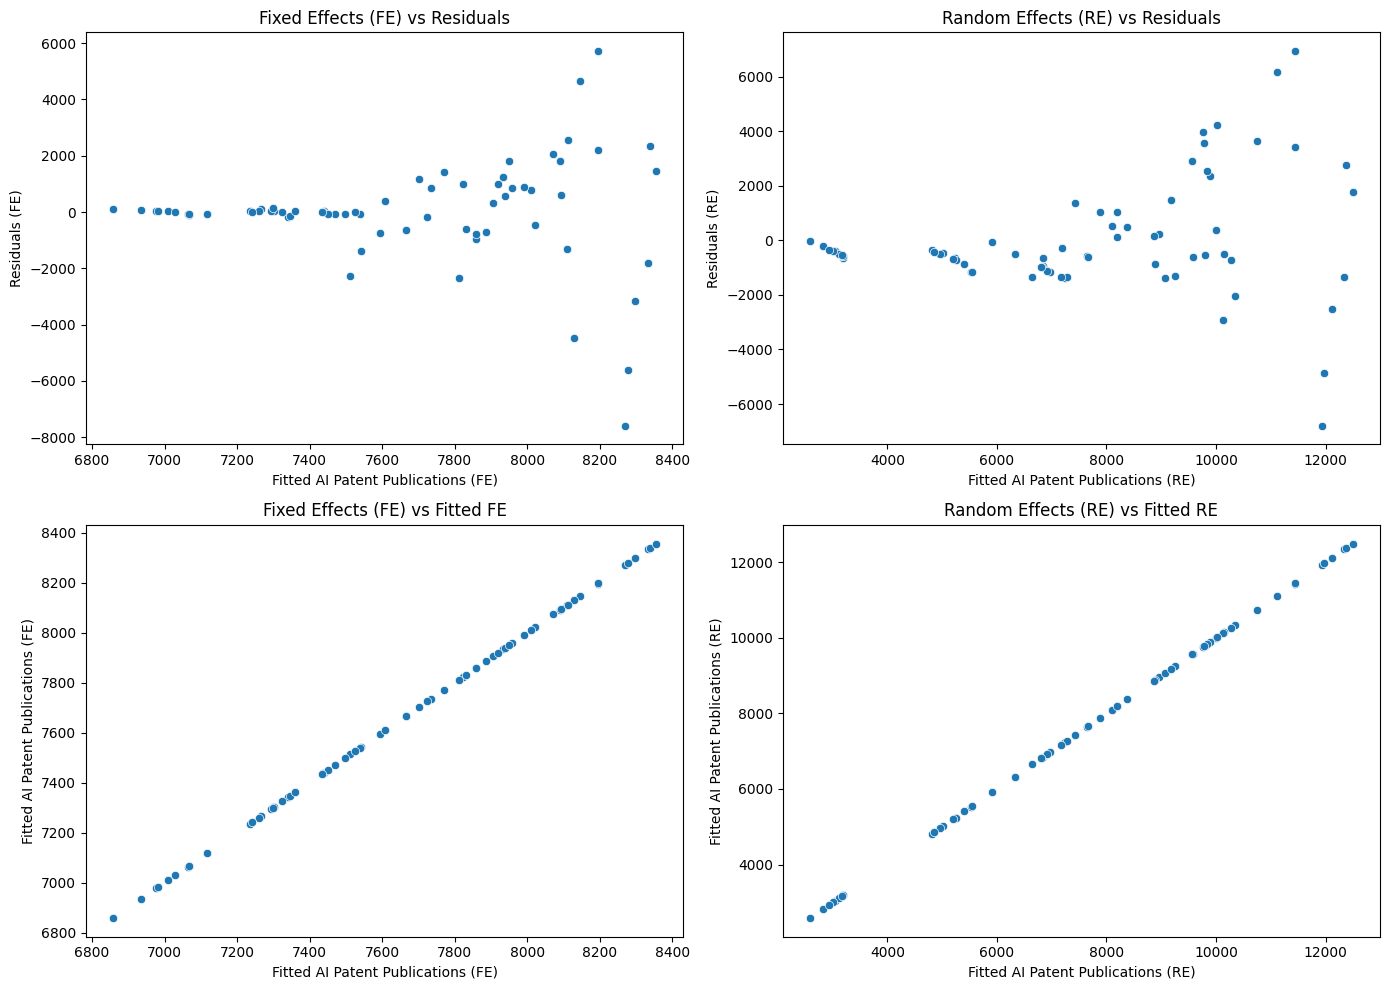

In [ ]:
# 고정효과 (FE)와 랜덤효과 (RE) 모델에서 예측값과 잔차를 1D 배열로 변환
fe_pred = fe_res_inv.fitted_values.values.flatten()
fe_resids = fe_res_inv.resids.values.flatten()

re_pred = re_res_inv.fitted_values.values.flatten()
re_resids = re_res_inv.resids.values.flatten()

# 2x2 서브플롯
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 왼쪽 상단: 고정효과(FE) 예측값 vs 잔차
sns.scatterplot(x=fe_pred, y=fe_resids, ax=axes[0, 0])
axes[0, 0].set_xlabel("Fitted AI Patent Publications (FE)")
axes[0, 0].set_ylabel("Residuals (FE)")
axes[0, 0].set_title("Fixed Effects (FE) vs Residuals")

# 오른쪽 상단: 랜덤효과(RE) 예측값 vs 잔차
sns.scatterplot(x=re_pred, y=re_resids, ax=axes[0, 1])
axes[0, 1].set_xlabel("Fitted AI Patent Publications (RE)")
axes[0, 1].set_ylabel("Residuals (RE)")
axes[0, 1].set_title("Random Effects (RE) vs Residuals")

# 왼쪽 하단: 고정효과(FE) 예측값 vs 고정효과(FE) 잔차
sns.scatterplot(x=fe_pred, y=fe_pred, ax=axes[1, 0])
axes[1, 0].set_xlabel("Fitted AI Patent Publications (FE)")
axes[1, 0].set_ylabel("Fitted AI Patent Publications (FE)")
axes[1, 0].set_title("Fixed Effects (FE) vs Fitted FE")

# 오른쪽 하단: 랜덤효과(RE) 예측값 vs 랜덤효과(RE) 잔차
sns.scatterplot(x=re_pred, y=re_pred, ax=axes[1, 1])
axes[1, 1].set_xlabel("Fitted AI Patent Publications (RE)")
axes[1, 1].set_ylabel("Fitted AI Patent Publications (RE)")
axes[1, 1].set_title("Random Effects (RE) vs Fitted RE")

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()